In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import jaccard_score
from scipy.optimize import linear_sum_assignment

In [3]:
def class_means(X, y):
    """Compute class means.
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input data.
    y : array-like of shape (n_samples,) or (n_samples, n_targets)
        Target values.
    Returns
    -------
    means : array-like of shape (n_classes, n_features)
        Class means.
    """
    classes, y = np.unique(y, return_inverse=True)
    cnt = np.bincount(y)
    means = np.zeros(shape=(len(classes), X.shape[1]))
    np.add.at(means, y, X)
    means /= cnt[:, None]
    return means

In [4]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(mean, cov, ax, n_std=3, **kwargs):

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1,1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0,0), width=ell_radius_x * 2, height=ell_radius_y * 2, **kwargs)
    
    # calculating the stdandarddeviation of x from  the squareroot of the variance
    # np.sqrt(cov[0, 0])
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mean[0]
    
    # calculating the stdandarddeviation of y from  the squareroot of the variance
    # np.sqrt(cov[1, 1])
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mean[1]
    
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
        
    ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    return pearson 

In [5]:
# generate train and test

In [6]:
seed = 2
np.random.seed(seed)

dim = 2

n_samples = 400
X, y = make_blobs(n_samples=n_samples, centers=6, cluster_std=0.5, random_state=seed)

n_outliers = int(0.05 * n_samples)
X_outliers = np.random.randn(n_outliers, dim) * 5

X = np.r_[X, X_outliers]
y = np.r_[y, -1*np.ones((n_outliers,))]

X = X.astype(np.float32)
y = y.astype(np.int64)

In [7]:
X_train, y_train = make_blobs(n_samples=10000, centers=100, cluster_std=0.5, random_state=seed+1)

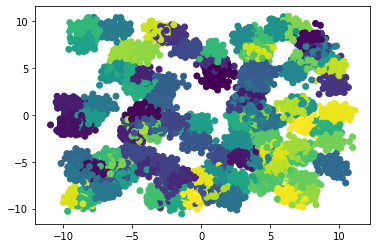

In [8]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train);

In [9]:
MULTIPLIER = 1 # ==0

In [10]:
def train_plda_sph_mle(X, y):

    classes, yy = np.unique(y, return_inverse=True)
    I = np.eye(len(classes))
    Y = I[yy]
    means = np.matmul(Y.T, X) / np.sum(Y, axis=0, keepdims=True).T
    #means = class_means(X, y)
    X_means = means[yy]
    X_c = X - X_means

    w = np.mean(X_c**2)
    b = np.mean((means - np.mean(means, axis=0) * MULTIPLIER)**2)
    return b, w

In [11]:
# dataset global mean
global_mean = np.mean(X_train, axis=0, keepdims=True) * MULTIPLIER
print(global_mean)

[[ 0.41018715 -0.50440021]]


In [12]:
# spherical PLDA
b, w = train_plda_sph_mle(X_train, y_train)

print(f"b = {b} \nw = {w}") # var = std**2

b = 31.836102906948494 
w = 0.24459778784235864


In [13]:
b/w

130.15695353494615

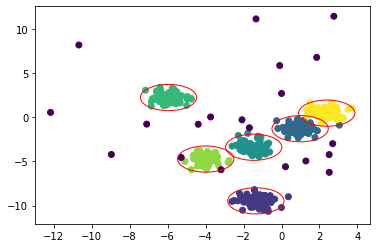

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plt.scatter(X[:, 0], X[:, 1], c=y);
means = class_means(X[y>=0], y[y>=0])
for c in np.unique(y):
    if c == -1:
        continue
    mask_class = y==c
    cov = np.eye(dim) * w
    confidence_ellipse(means[c], cov, ax, n_std=3, facecolor='none', edgecolor='red');
    

In [15]:
from clustering_vbhmm_plda import VB_diarization, VB_diarization_UP
from clustering_ahc_plda import CluteringAHC

In [16]:
# Let's compare two implementations on random datasets
if True:
    N = 100
    for i in tqdm(range(10)):

        np.random.seed(i)

        D = int(np.random.rand()*100)+1
        R = int(np.random.rand() * D)+1

        scaler = np.random.rand() * 10
        fea = np.random.randn(N, D) * scaler

        V = np.random.randn(R, D)
        sm = np.random.randn(D)
        siE = np.random.rand(D) * 10



        np.random.seed(42)
        iE = np.diag(siE)
        posteriors, sp, L = VB_diarization(fea, sm, iE, V, 
                                  pi=None, 
                                  gamma=None, 
                                  maxSpeakers=10, 
                                  maxIters=10, 
                                  epsilon=1e-6, 
                                  loopProb=0.5, 
                                  Fa=1.0, 
                                  Fb=1.0)

        np.random.seed(42)
        iE = np.tile(siE, (N, 1))
        posteriors_up, sp_up, L_up = VB_diarization_UP(fea, sm, iE, V, 
                                  pi=None, 
                                  gamma=None, 
                                  maxSpeakers=10, 
                                  maxIters=10, 
                                  epsilon=1e-6, 
                                  loopProb=0.5, 
                                  Fa=1.0, 
                                  Fb=1.0)

        # Compare
        diff = np.mean((posteriors - posteriors_up)**2)
        print(f"diff = {diff}, L = {L[-1]}, L_up = {L_up[-1]}")




 10%|█         | 1/10 [00:00<00:01,  7.05it/s]

diff = 2.171792476760026e-21, L = [-398372.74898852786], L_up = [-398372.7489885279]
diff = 1.075334796318936e-25, L = [-2681.9435978199226], L_up = [-2681.9435978199153]


 40%|████      | 4/10 [00:00<00:00,  8.18it/s]

diff = 1.231864800304496e-21, L = [-387513.1704988656], L_up = [-387513.1704988657]
diff = 3.119198828263961e-22, L = [-95851.08666760034], L_up = [-95851.08666760029]


 60%|██████    | 6/10 [00:00<00:00,  7.37it/s]

diff = 1.9168694409543719e-19, L = [-2203448.00957169], L_up = [-2203448.0095716882]
diff = 2.4977409675839377e-21, L = [-17654.879782279775], L_up = [-17654.879782280743]


 80%|████████  | 8/10 [00:01<00:00,  7.16it/s]

diff = 1.6306400674181987e-19, L = [-1309680.9390647032], L_up = [-1309680.9390647046]
diff = 4.246815264683076e-25, L = [-6852.313551420437], L_up = [-6852.313551420503]


100%|██████████| 10/10 [00:01<00:00,  7.19it/s]

diff = 7.144892316679475e-20, L = [-1399633.500838944], L_up = [-1399633.5008389426]
diff = 2.1958237044483726e-25, L = [-1779.0596629754991], L_up = [-1779.059662975501]


In [17]:
# transform the input data

T = np.eye(dim) / np.sqrt(w)

fea = np.matmul(X - global_mean, T)

In [18]:
T

array([[2.02196548, 0.        ],
       [0.        , 2.02196548]])

In [19]:
b/w

130.15695353494615

In [20]:
# T @ I @ T.T = eye, T @ D @ T.T = diagonal
W = w*np.eye(dim)
B = b*np.eye(dim)
print(T.T @ W @ T)
print(T.T @ B @ T)

[[1. 0.]
 [0. 1.]]
[[130.15695353   0.        ]
 [  0.         130.15695353]]


In [21]:
#check that w==1.0
b_transformed, w_transformed = train_plda_sph_mle(fea[y>=0], y[y>=0])
print(f"b = {b_transformed} \nw = {w_transformed}") # var = std**2

b = 45.700596016722535 
w = 1.0278352623967175


In [22]:
# Use VB-HMM for x-vector clustering. Instead of i-vector extractor model, we use PLDA
# => GMM with only 1 component, V derived accross-class covariance,
# and iE is inverse within-class covariance (i.e. identity)

sm = np.zeros(dim)
siE = np.ones(dim) # inverse covariance matrix diagonals, 1/w = 1/1 = 1
sV = np.sqrt(np.ones(dim) * b/w)
V = np.diag(sV)


maxSpeakers=10
maxIters=50
loopProb=0
Fa=1.0 # feature scaling factor - to counteract inadequate assumption of statistical independence
Fb=1.0 # speaker regularization coefficient - penalty for overcomplexity

# https://github.com/felixfuyihui/AISHELL-4/blob/master/sd/scripts/run_cluster.sh
# Fa 0.3 
# Fb 17
# loopP 0.99

# NOTE: return_clusters is only required here for visualization, set to False


# ORIGINAL SPACE
np.random.seed(42)
posteriors, sp, L, _, __ = VB_diarization(X, global_mean, np.eye(dim)/w, np.eye(dim)*np.sqrt(b), 
                          pi=None, 
                          gamma=None, 
                          maxSpeakers=maxSpeakers, 
                          maxIters=maxIters, 
                          epsilon=1e-6, 
                          loopProb=loopProb, 
                          Fa=Fa, 
                          Fb=Fb, return_clusters=True)


# TRANSFORMED SPACE
np.random.seed(42)
posteriors_tr, sp, L, mu, Sigma = VB_diarization(fea, sm, np.diag(siE), V, 
                          pi=None, 
                          gamma=None, 
                          maxSpeakers=maxSpeakers, 
                          maxIters=maxIters, 
                          epsilon=1e-6, 
                          loopProb=loopProb, 
                          Fa=Fa, 
                          Fb=Fb, return_clusters=True)




diff = np.mean((posteriors - posteriors_tr)**2)
print(diff)



#############

# Let's assign lower confidence to outliers
INFINITY = 99999999999
estimated_precisions = np.ones((fea.shape[0],)) * INFINITY # vector of confidence estimates for each data point
estimated_precisions[y<0] = 0.1 

# NOTE: estimated_precisions in the ORIGINAL SPACE !!!

estimated_precisions = np.tile(estimated_precisions.reshape(-1, 1), (1, dim))

# ORIGINAL SPACE
model_precisions = 1 / (np.ones_like(X) * w + 1/estimated_precisions) 
np.random.seed(42)
posteriors_up, sp_up, L_up, __, __ = VB_diarization_UP(X, global_mean, model_precisions, np.eye(dim)*np.sqrt(b), 
                          pi=None, 
                          gamma=None, 
                          maxSpeakers=maxSpeakers, 
                          maxIters=maxIters, 
                          epsilon=1e-6, 
                          loopProb=loopProb, 
                          Fa=Fa, 
                          Fb=Fb, return_clusters=True)


# TRANSFORMED SPACE
estimated_precisions_tr = estimated_precisions * w

model_precisions_tr = 1 / (np.ones_like(X) + 1/estimated_precisions_tr) 
np.random.seed(42)
posteriors_up_tr, sp_up, L_up, mu_up, Sigma_up = VB_diarization_UP(fea, sm, model_precisions_tr, V, 
                          pi=None, 
                          gamma=None, 
                          maxSpeakers=maxSpeakers, 
                          maxIters=maxIters, 
                          epsilon=1e-6, 
                          loopProb=loopProb, 
                          Fa=Fa, 
                          Fb=Fb, return_clusters=True)






diff = np.mean((posteriors_up - posteriors_up_tr)**2)
print(diff)


1.4297042687112682e-24
7.635536661216807e-16


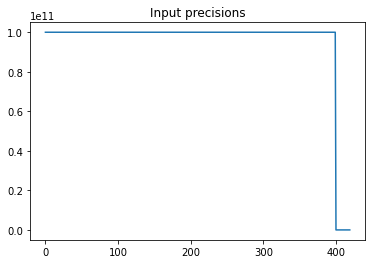

In [23]:
plt.plot(estimated_precisions[:, 0]);
plt.title("Input precisions");

In [24]:
y_pred = np.argmax(posteriors, axis=1)
y_pred_up = np.argmax(posteriors_up, axis=1)

print(f'True number of clusters: {len(np.unique(y[y>=0]))}')
print(f'Predicted number of clusters: {len(np.unique(y_pred))}')
print(f'Predicted number of clusters, UP: {len(np.unique(y_pred_up))}')

True number of clusters: 6
Predicted number of clusters: 9
Predicted number of clusters, UP: 7


In [25]:
def entropy(prob, axis=None, keepdims=False): 
    return -np.sum(prob * np.log(prob + 1e-16), axis=axis, keepdims=keepdims)

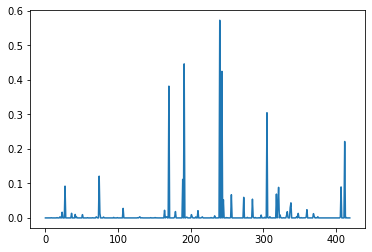

In [26]:
pred_unvertainty = entropy(posteriors, axis=1)
plt.plot(pred_unvertainty);

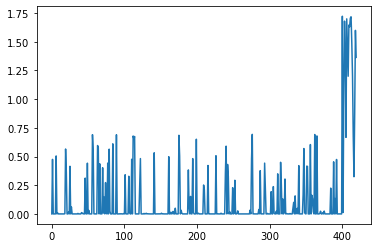

In [27]:
pred_unvertainty = entropy(posteriors_up, axis=1)
plt.plot(pred_unvertainty);

In [28]:
T_inv = np.linalg.inv(T)

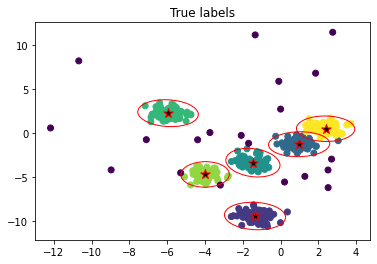

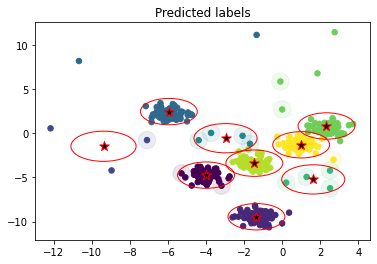

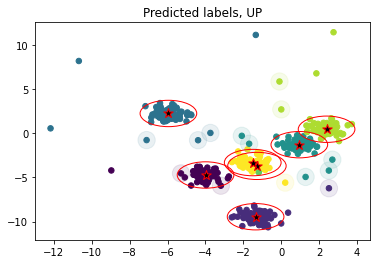

In [29]:
unc_threshold = np.log(maxSpeakers) * 0.5

fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(X[:, 0], X[:, 1], c=y);
means = class_means(X[y>=0], y[y>=0])
plt.scatter(means[:, 0], means[:, 1], c='k', s=100, edgecolor='red', marker="*");
#plt.plot(means[:, 0], means[:, 1], 'k*', markersize=10);
for c in np.unique(y):
    if c == -1:
        continue
    mask_class = y==c
    cov = np.cov(X[mask_class], rowvar=False)
    confidence_ellipse(means[c], cov, ax, n_std=3, facecolor='none', edgecolor='red');
plt.title('True labels');

fig, ax = plt.subplots(nrows=1, ncols=1)
mask = pred_unvertainty < unc_threshold
mask_inv = np.logical_not(mask)
plt.scatter(X[:, 0], X[:, 1], c=y_pred[:], s=30);
plt.scatter(X[mask_inv, 0], X[mask_inv, 1], c=y_pred[mask_inv], s=300, alpha=0.1);

means = mu @ T_inv + global_mean
for c in np.unique(y_pred):
    mask_class = y_pred==c
    
    mean = mu[c]
    cov = Sigma[c, :, :]

    mean = means[c]
    plt.scatter(mean[0], mean[1], c='k', s=100, edgecolor='red', marker="*");
    #plt.plot(mean[0], mean[1], 'k*', markersize=10);
    cov = T_inv.T @ cov @ T_inv
    confidence_ellipse(mean, cov, ax, n_std=3, facecolor='none', edgecolor='red');
    ;
plt.title('Predicted labels');

fig, ax = plt.subplots(nrows=1, ncols=1)
mask = pred_unvertainty < unc_threshold
mask_inv = np.logical_not(mask)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_up[:], s=30);
plt.scatter(X[mask_inv, 0], X[mask_inv, 1], c=y_pred_up[mask_inv], s=300, alpha=0.1);

means = mu_up @ T_inv + global_mean
for c in np.unique(y_pred_up):
    mask_class = y_pred_up==c
    
    mean = mu_up[c]
    cov = Sigma_up[c, :, :]

    mean = means[c]
    plt.scatter(mean[0], mean[1], c='k', s=100, edgecolor='red', marker="*");
    #plt.plot(mean[0], mean[1], 'k*', markersize=10);
    cov = T_inv.T @ cov @ T_inv
    confidence_ellipse(mean, cov, ax, n_std=3, facecolor='none', edgecolor='red');
    
plt.title('Predicted labels, UP');

In [30]:
posteriors_up.mean(0)

array([1.64745035e-001, 1.62053202e-001, 7.05862478e-128, 1.71487487e-001,
       1.65623517e-001, 1.43295749e-116, 3.09053019e-002, 1.68130200e-001,
       1.37055258e-001, 8.31432944e-019])

In [31]:
Tr = np.eye(dim) / np.sqrt(b)

fea = np.matmul(X - global_mean, Tr)

In [32]:
Tr

array([[0.17723115, 0.        ],
       [0.        , 0.17723115]])

In [33]:
b/w

130.15695353494615

In [34]:
# T @ I @ T.T = eye, T @ D @ T.T = diagonal
W = w*np.eye(dim)
B = b*np.eye(dim)
print(Tr.T @ W @ Tr)
print(Tr.T @ B @ Tr)

[[0.00768303 0.        ]
 [0.         0.00768303]]
[[1. 0.]
 [0. 1.]]


In [35]:
w_inv_tr = 1/w * b
w_inv_tr

130.15695353494618

In [36]:
# assert alpha >= 0 
# assert 0<= beta <= 1
# See 8.2.1 in https://github.com/bsxfan/meta-embeddings/blob/master/theory/meta-embeddings_30Nov17_presentation.pdf
alpha, beta = 1.0, 0.1

w_inv_diag_tr = np.full(dim, w_inv_tr)

In [38]:
# TRANSFORMED SPACE

np.random.seed(42)
ahc = CluteringAHC(w_inv_diag_tr, alpha, beta, fea, B=None)
y_pred = ahc.cluster()


# Let's assign lower confidence to outliers
INFINITY = 99999999999999
estimated_precisions = np.ones((fea.shape[0],)) * INFINITY # vector of confidence estimates for each data point
estimated_precisions[y<0] = 0.1 

# NOTE: estimated_precisions in the ORIGINAL SPACE !!!

B = np.tile(estimated_precisions.reshape(-1, 1), (1, dim))

B_tr = B * b

np.random.seed(42)
ahc_up = CluteringAHC(w_inv_diag_tr, alpha, beta, fea, B=B_tr)
y_pred_up = ahc_up.cluster()

In [39]:
print(f'True number of clusters: {len(np.unique(y[y>=0]))}')
print(f'Predicted number of clusters: {len(np.unique(y_pred))}')
print(f'Predicted number of clusters, UP: {len(np.unique(y_pred_up))}')

True number of clusters: 6
Predicted number of clusters: 19
Predicted number of clusters, UP: 7


In [40]:
Tr_inv = np.linalg.inv(Tr)

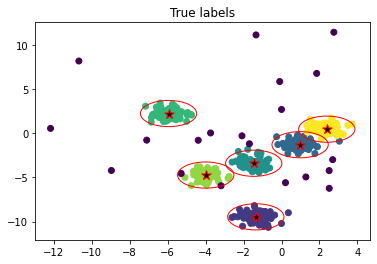

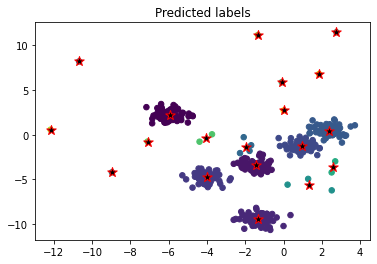

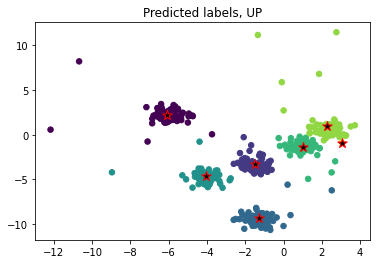

In [42]:
fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(X[:, 0], X[:, 1], c=y);
means = class_means(X[y>=0], y[y>=0])
plt.scatter(means[:, 0], means[:, 1], c='k', s=100, edgecolor='red', marker="*");
for c in np.unique(y):
    if c == -1:
        continue
    mask_class = y==c
    #cov = np.cov(X[mask_class], rowvar=False)
    cov = np.diag(1 / w_inv_diag_tr)
    cov = Tr_inv.T @ cov @ Tr_inv
    confidence_ellipse(means[c], cov, ax, n_std=3, facecolor='none', edgecolor='red');
plt.title('True labels');


fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred, s=30);
for c in np.unique(y_pred):
    mask_class = y_pred==c
    mean = np.mean(X[mask_class], axis=0)
    plt.scatter(mean[0], mean[1], c='k', s=100, edgecolor='red', marker="*");
    #plt.plot(mean[0], mean[1], 'k*', markersize=10);
#     if np.sum(mask_class) > 2:
#         cov = np.cov(X[mask_class], rowvar=False)
#         confidence_ellipse(mean, cov, ax, n_std=3, facecolor='none', edgecolor='red');
plt.title('Predicted labels');


fig, ax = plt.subplots(nrows=1, ncols=1)
plt.scatter(X[:, 0], X[:, 1], c=y_pred_up[:], s=30);
for c in np.unique(y_pred_up):
    mask_class = y_pred_up==c
    mean = np.mean(X[mask_class], axis=0)
    plt.scatter(mean[0], mean[1], c='k', s=100, edgecolor='red', marker="*");
    #plt.plot(mean[0], mean[1], 'k*', markersize=10);
#     if np.sum(mask_class) > 2:
#         cov = np.cov(X[mask_class], rowvar=False)
#         confidence_ellipse(mean, cov, ax, n_std=3, facecolor='none', edgecolor='red');
plt.title('Predicted labels, UP');

In [3]:
def joint_diagonalization(I, D, return_diagonal=True):
    # T: T @ I @ T.T = eye, T @ D @ T.T = diagonal
    lmbda, L = np.linalg.eig(np.linalg.inv(I))
    Lmbda_sqrt = np.diag(lmbda ** 0.5)
    _, U = np.linalg.eig(Lmbda_sqrt @ L.T @ D @ L @ Lmbda_sqrt)
    T = U.T @ Lmbda_sqrt @ L.T
    if return_diagonal:
        return T, np.diag(T @ D @ T.T)
    else:
        return T
    
# plda_mu, plda_tr, plda_psi = kaldi_plda
# W = np.linalg.inv(plda_tr.T.dot(plda_tr))
# B = np.linalg.inv((plda_tr.T / plda_psi).dot(plda_tr))

In [16]:
L = np.random.randn(2, 2)
B = L.T @ L

L = np.random.randn(2, 2)
W = L.T @ L

#B = np.eye(2) * 64
#W = np.eye(2) * 16

In [31]:
B, W

(array([[0.41859748, 0.7007735 ],
        [0.7007735 , 3.85528408]]),
 array([[0.35078386, 0.08819649],
        [0.08819649, 0.90019809]]))

In [17]:
T, B_diag = joint_diagonalization(W, B, return_diagonal=True)

In [18]:
B_diag

array([0.83208062, 4.38090523])

In [19]:
T

array([[-1.68578788,  0.34048849],
       [-0.28438534, -1.01142956]])

In [20]:
from scipy.linalg import eigh

acvar, wccn = eigh(B, W)
plda_psi = acvar
plda_tr = wccn.T

In [21]:
plda_psi

array([0.83208062, 4.38090523])

In [22]:
plda_tr

array([[-1.68578788,  0.34048849],
       [ 0.28438534,  1.01142956]])

In [23]:
plda_tr @ W @ plda_tr.T # eye

array([[1.00000000e+00, 0.00000000e+00],
       [5.55111512e-17, 1.00000000e+00]])

In [24]:
plda_tr @ B @ plda_tr.T # = np.diag(plda_psi)

array([[ 8.32080620e-01, -8.32667268e-17],
       [ 0.00000000e+00,  4.38090523e+00]])

In [25]:
plda_tr

array([[-1.68578788,  0.34048849],
       [ 0.28438534,  1.01142956]])

In [28]:
inv_plda_tr = np.linalg.inv(plda_tr)

In [29]:
inv_plda_tr.T @ np.diag(1/plda_psi) @ inv_plda_tr

array([[ 0.38434761, -0.0937682 ],
       [-0.0937682 ,  0.24270897]])

In [32]:
plda_tr @ plda_tr.T

array([[ 2.95781318, -0.13503324],
       [-0.13503324,  1.10386478]])

In [33]:
W_ = np.linalg.inv(plda_tr.T.dot(plda_tr))
B_ = np.linalg.inv((plda_tr.T / plda_psi).dot(plda_tr))

In [35]:
W, W_

(array([[0.35078386, 0.08819649],
        [0.08819649, 0.90019809]]),
 array([[0.35078386, 0.08819649],
        [0.08819649, 0.90019809]]))

In [36]:
B, B_

(array([[0.41859748, 0.7007735 ],
        [0.7007735 , 3.85528408]]),
 array([[0.41859748, 0.7007735 ],
        [0.7007735 , 3.85528408]]))